In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from downstream import dstream
import matplotlib as mpl
import more_itertools as mit
import numpy as np
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-06-01T12:36:47.588954+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1029-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

more_itertools: 9.1.0
downstream    : 1.11.0
matplotlib    : 3.10.0
teeplot       : 1.4.2
numpy         : 2.1.2
polars        : 1.9.0
pylib         : 0.0.0
seaborn       : 0.13.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = False
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2024-10-20-qos-dstream-vs-naive-tilted"
)
teeplot_subdir


'2025-01-18-qos-dstream-vs-naive-tilted'

In [5]:
num_items = 10_000


## Define


In [6]:
def calc_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    return max(
        (segment_length - 1) / ((segment_total - cumulative) or 1)
        for cumulative, segment_length in zip(
            it.accumulate([0, *segment_lengths]),
            [*segment_lengths, 1],
        )
    )


In [7]:
def calc_max_gaps_naive_doubling_tilted(
    buffer_size: int, num_ingests: int
) -> list[int]:
    segment_lengths = []
    max_gaps = [0]
    for i in range(num_ingests):

        if (len(segment_lengths) == buffer_size):
            segment_lengths = [
                a + b
                for a, b in mit.batched(segment_lengths, 2)
            ]
        segment_lengths.append(1)

        assert sum(segment_lengths) == i + 1
        max_gaps.append(calc_qos_from_segment_lengths(segment_lengths))

    return max_gaps[:-1]


In [8]:
def calc_max_gaps_dstream(buffer_size: int, num_items: int) -> list[int]:
    return [
        calc_qos_from_segment_lengths(
            [b - a for a, b in mit.pairwise(
            sorted(
                dstream.tilted_algo.lookup_ingest_times_eager(
                    buffer_size, i + 1
                ),
            ))],
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


In [9]:
def calc_max_gaps_zhao_tilted(buffer_size: int, num_items: int) -> list[int]:
    segment_lengths = []
    max_gaps = [0]
    for k in range(num_items):

        segment_lengths.append(1)
        for i, j in it.pairwise(reversed(range(len(segment_lengths) - 1))):
            if segment_lengths[i] == segment_lengths[j]:
                segment_lengths[i] += segment_lengths[j]
                del segment_lengths[j]
                break

        assert sum(segment_lengths) == k + 1
        max_gaps.append(calc_qos_from_segment_lengths(segment_lengths))

    return max_gaps[:-1]


In [10]:
def calc_max_gaps_zhao_tilted_full(
    buffer_size: int, num_items: int
) -> list[int]:
    segment_lengths = [0] * buffer_size
    max_gaps = [0]
    for k in range(num_items):
        if k >= buffer_size:
            for j in range(buffer_size):
                if (
                    segment_lengths[j] > segment_lengths[j + 1]
                    or segment_lengths[j + 1] == 0
                ):
                    segment_lengths[j] -= 2
                    segment_lengths[j + 1] += 1
                    break

        segment_lengths[0] += 1

        segment_length_values = [
            2 ** i
            for i, x in enumerate(segment_lengths)
            for __ in range(x)
        ]
        segment_length_values = [*reversed(segment_length_values)]

        assert sum(segment_length_values) == k + 1
        max_gaps.append(
            calc_qos_from_segment_lengths(segment_length_values),
        )

    return max_gaps[:-1]


## Example Plot


In [11]:
def make_df(buffer_size: int) -> pl.DataFrame:
    return pl.concat(
        [
            pl.DataFrame(
                {
                    "Algorithm": "doubling tilted",
                    "Gap Size Cost": calc_max_gaps_naive_doubling_tilted(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "dstream tilted",
                    "Gap Size Cost": calc_max_gaps_dstream(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "zhao tilted",
                    "Gap Size Cost": calc_max_gaps_zhao_tilted(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "zhao tilted full",
                    "Gap Size Cost": calc_max_gaps_zhao_tilted_full(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
        ]
    )


teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


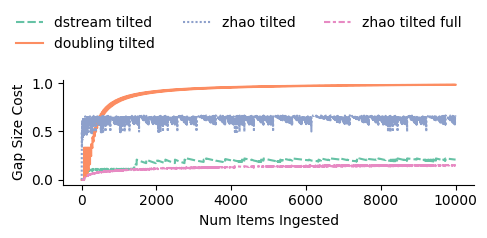

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.69
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


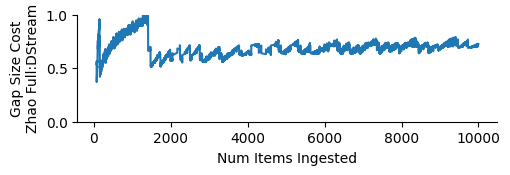

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


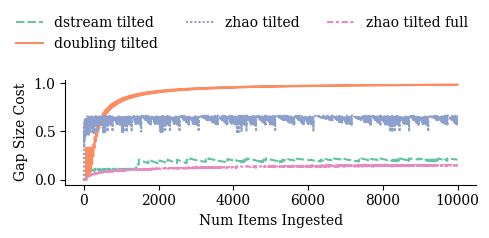

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.69
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


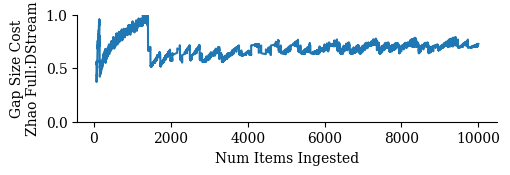

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


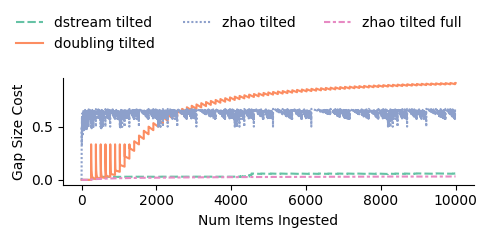

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


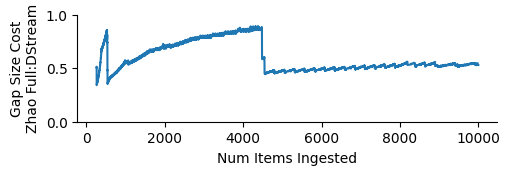

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


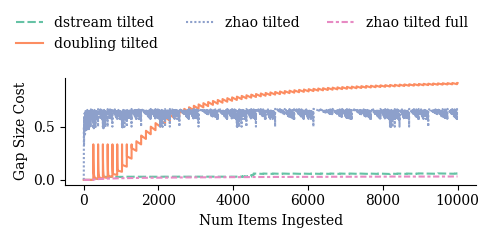

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


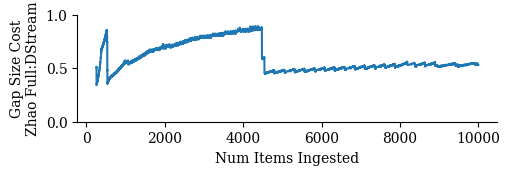

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


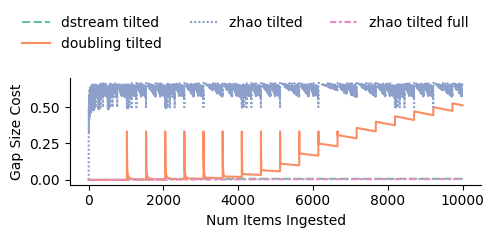

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


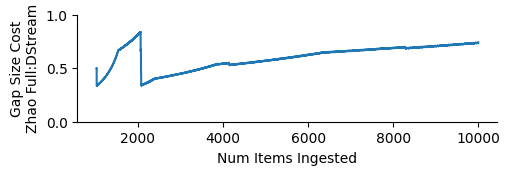

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


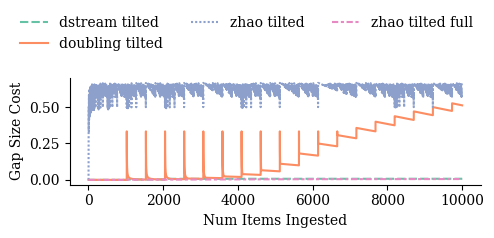

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


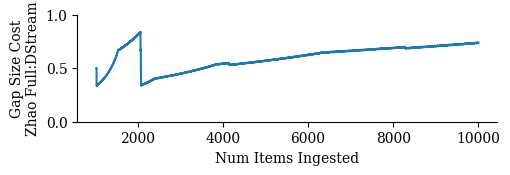

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


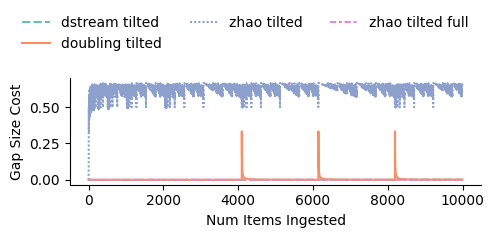

dfp['ratio'].min()=0.33
dfp['ratio'].replace(inf, nan).dropna().mean()=0.54
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


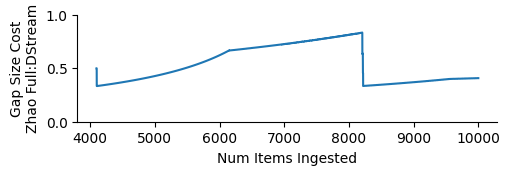

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


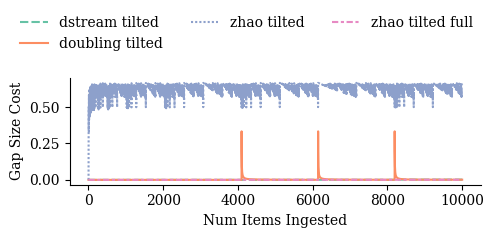

dfp['ratio'].min()=0.33
dfp['ratio'].replace(inf, nan).dropna().mean()=0.54
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/buffer_size=4096+font.family=serif+kind=line+palette=set2+viz=relplot+x=num-items-ingested+y=ratio+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


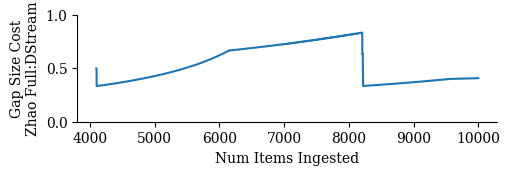

In [12]:
for buffer_size in [64, 256, 1024, 4096]:
    df = make_df(buffer_size)
    for rc in [{}, {"font.family": "serif"}]:
        with mpl.rc_context(rc=rc):
            with tp.teed(
                sns.relplot,
                df,
                x="Num Items Ingested",
                y="Gap Size Cost",
                hue="Algorithm",
                hue_order=[
                    "dstream tilted",
                    "doubling tilted",
                    "zhao tilted",
                    "zhao tilted full",
                ],
                style="Algorithm",
                aspect=2.8,
                kind="line",
                height=1.8,
                palette="Set2",
                teeplot_outattrs={
                    "buffer_size": buffer_size,
                    **rc,
                },
                teeplot_subdir=teeplot_subdir,
            ) as g:
                sns.move_legend(
                    g,
                    "lower center",
                    bbox_to_anchor=(0.4, 1),
                    ncol=3,
                    title=None,
                    frameon=False,
                )

            dfp = df.pivot(
                index="Num Items Ingested",
                on="Algorithm",
                values="Gap Size Cost",
            ).to_pandas()
            dfp["ratio"] = (
                dfp["zhao tilted full"] / dfp["dstream tilted"]
            )
            inf, nan = np.inf, np.nan
            print(
                f"{dfp['ratio'].min()=:.2f}",
                f"{dfp['ratio'].replace(inf, nan).dropna().mean()=:.2f}",
                sep="\n",
            )
            with tp.teed(
                sns.relplot,
                dfp,
                x="Num Items Ingested",
                y="ratio",
                aspect=2.8,
                kind="line",
                height=1.8,
                palette="Set2",
                teeplot_outattrs={
                    "buffer_size": buffer_size,
                    **rc,
                },
                teeplot_subdir=teeplot_subdir,
            ) as g:
                g.set(ylim=(0, 1))
                g.set(ylabel="Gap Size Cost\nZhao Full:DStream")
